In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from maxentnuc.analysis.domain_analyzer import DomainAnalyzer, get_boundary_loops, Domains
from maxentnuc.analysis.mei_analyzer import MEIAnalyzer
from maxentnuc.analysis.analysis import *
from maxentnuc.analysis.insulation import *

from matplotlib.colors import LogNorm
import os
from cooltools.api.insulation import _insul_diamond_dense
from neighbor_balance.plotting import parse_region, format_ticks, ContactMap, apply_matplotlib_style, load_bw, bin_track

from maxentnuc.analysis.imaging import STORMSimulator, ClutchAnalyzer, ChromSTEMAnalyzer, ChromSTEMSimulator, plot_density

def myhist(ax, data, bins, label, precision=2):
    if data.min() < bins[0]:
        print(f"Warning: data min {data.min()} < bins[0] {bins[0]}; {np.sum(data < bins[0])} values will be excluded")
    if data.max() > bins[-1]:
        print(f"Warning: data max {data.max()} > bins[-1] {bins[-1]}; {np.sum(data > bins[-1])} values will be excluded")
    label = f'{label} mean={np.mean(data):.{precision}f}, med={np.median(data):.{precision}f}'
    ax.hist(data, bins=bins, histtype='step', label=label, weights=np.ones_like(data)/len(data))
    ax.set_xlim(bins[0], bins[-1])

omics = '/home/joepaggi/orcd/pool/omics'
mei_runs = '/orcd/data/binz/001/joepaggi/mei_runs'

apply_matplotlib_style()

In [3]:
prod = {
    'klf1': {'config': f'{mei_runs}/klf1/v3/config.yaml', 'iteration': 11},
    'fbn2' : {'config': f'{mei_runs}/fbn2/v2/config.yaml', 'iteration': 12},
}

for name in prod:
    prod[name]['mei'] = MEIAnalyzer(prod[name]['config'], scale=0.1)

In [4]:
trajectories = {}
for name, info in prod.items():
    trajectories[name] = info['mei'].get_positions(info['iteration'], skip=110, burnin=0)
    trajectories[name] = trajectories[name].reshape(-1, *trajectories[name].shape[-2:])

/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not

/orcd/data/binz/001/joepaggi/mei_runs/klf1/v3/011_trajectory.*.dcd


INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not guess any new values for masses attribute
INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.

INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not guess any new values for masses attribute
INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.

/orcd/data/binz/001/joepaggi/mei_runs/fbn2/v2/012_trajectory.*.dcd


INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not guess any new values for masses attribute


# Comparison to ChromSTEM

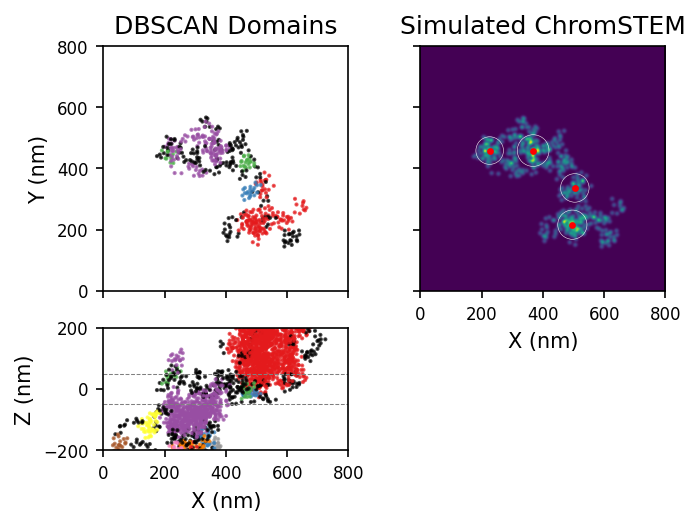

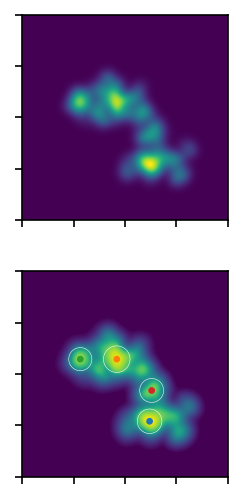

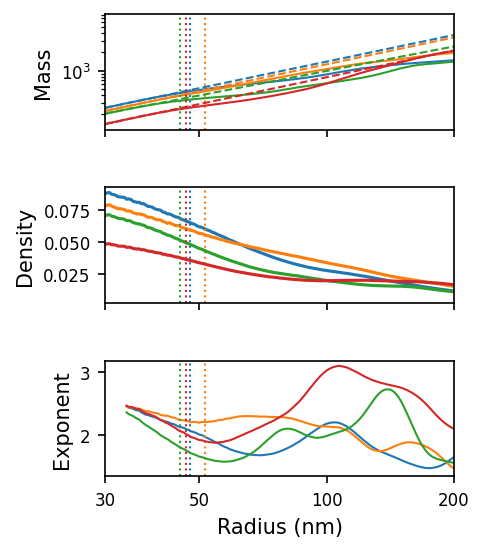

In [5]:
import matplotlib.ticker as mticker

positions = trajectories['klf1'][0]

stem_simulator = ChromSTEMSimulator(width=800)
stem_analyzer = ChromSTEMAnalyzer(filter_radius=10)
dbscan_analyzer = DomainAnalyzer(30, 200, min_loop_size=2, add_boundary_linkers=True)


stem_image = stem_simulator.simulate(positions)
stem_results = stem_analyzer.run(stem_image)

domain = dbscan_analyzer.analyze_frame(positions)
stem_mask = stem_simulator.slice_weights(positions) > 0.5

_positions = positions.copy()
_positions[:, 0] += stem_simulator.width / 2
_positions[:, 1] += stem_simulator.width / 2

f, ax = plt.subplots(2, 2, figsize=(5, 3.5), sharex=True, sharey='row', gridspec_kw={'height_ratios':[800, 400]})
s = 1
alpha=0.7
ax[0, 0].set_title('DBSCAN Domains')
ax[0, 0].scatter(_positions[stem_mask, 0], _positions[stem_mask, 1], c=domain.labels[stem_mask], cmap=domain.colors(), s=s, alpha=alpha, vmin=domain.labels.min(), vmax=domain.labels.max())
ax[0, 0].set_aspect('equal')

ax[1, 0].scatter(_positions[:, 0], _positions[:, 2], c=domain.labels, cmap=domain.colors(), s=s, alpha=alpha, vmin=domain.labels.min(), vmax=domain.labels.max())
ax[1, 0].set_ylim(-200, 200)
ax[1, 0].axhline(-50, c='gray', ls='--', lw=0.5)
ax[1, 0].axhline(50, c='gray', ls='--', lw=0.5)
ax[1, 0].set_aspect('equal')

ax[0, 1].set_title('Simulated ChromSTEM')
stem_analyzer.plot_domains(stem_results, ax=ax[0, 1])

ax[0, 0].set_ylabel('Y (nm)')
ax[0, 0].set_xlim(0, stem_simulator.width)

ax[1, 0].set_ylabel('Z (nm)')
ax[1, 0].set_xlabel('X (nm)')
ax[1, 0].set_xlabel('X (nm)')

ax[0, 1].set_xlabel('X (nm)')
ax[0, 1].tick_params(axis="x", labelbottom=True)

ax[1, 1].axis('off')
plt.savefig('img/chromstem_example.pdf')
plt.show()

f, ax = plt.subplots(2, figsize=(2, 4), gridspec_kw={'hspace':0.25})
stem_analyzer.plot_density(stem_results['h_filtered'], ax=ax[0])
stem_analyzer.plot_density(stem_results['h_contrast'], ax=ax[1])
colors = [f'C{i}' for i in range(len(stem_results['peaks']))]
stem_analyzer.plot_peaks(stem_results['peaks'], rfs=stem_results['rfs'], ax=ax[1], colors=colors)
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
plt.savefig('img/chromstem_densities.pdf')
plt.show()

f, ax = stem_analyzer.plot_rf_fit(stem_results, max_peaks=5, add_space=True)
ax[-1].set_xlim(30, 200)
ax[-1].minorticks_off()
ax[-1].set_xticks([30, 50, 100, 200])
ax[-1].set_xticklabels(['30', '50', '100', '200'])
plt.savefig('img/chromstem_rf_fit.pdf')
plt.show()

In [6]:
from tqdm import tqdm

simulator = ChromSTEMSimulator(width=1600)
analyzer = ChromSTEMAnalyzer(filter_radius=10)

all_results = {}
for name, trajectory in trajectories.items():
    all_results[name] = []
    for positions in tqdm(trajectory):
        h = simulator.simulate(positions)
        results = analyzer.run(h)
        all_results[name] += [results]

  0%|          | 0/160 [00:00<?, ?it/s]

 51%|█████     | 81/160 [14:36<15:29, 11.77s/it]/orcd/home/002/joepaggi/maxentnuc/maxentnuc/analysis/imaging.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  opt, _ = curve_fit(power_law, x, y)
100%|██████████| 160/160 [29:49<00:00, 11.18s/it]


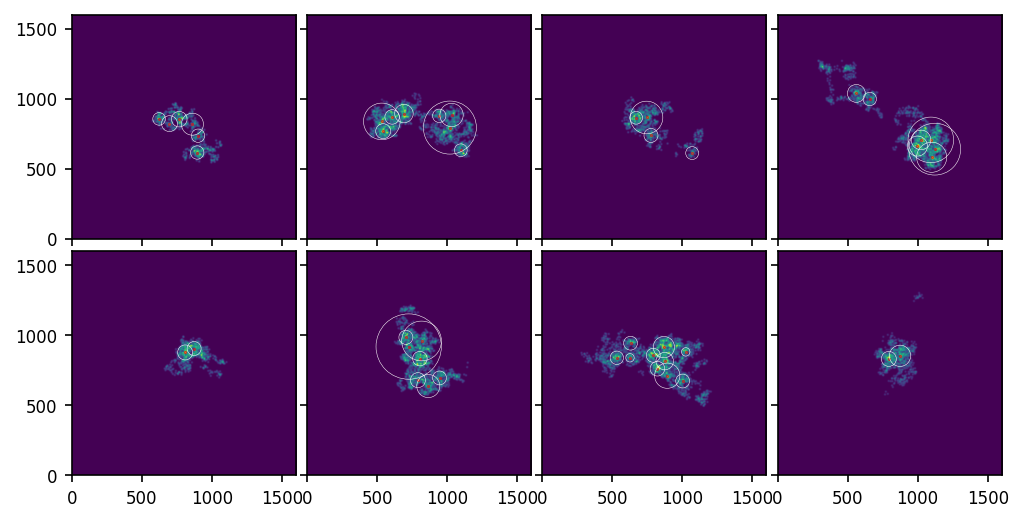

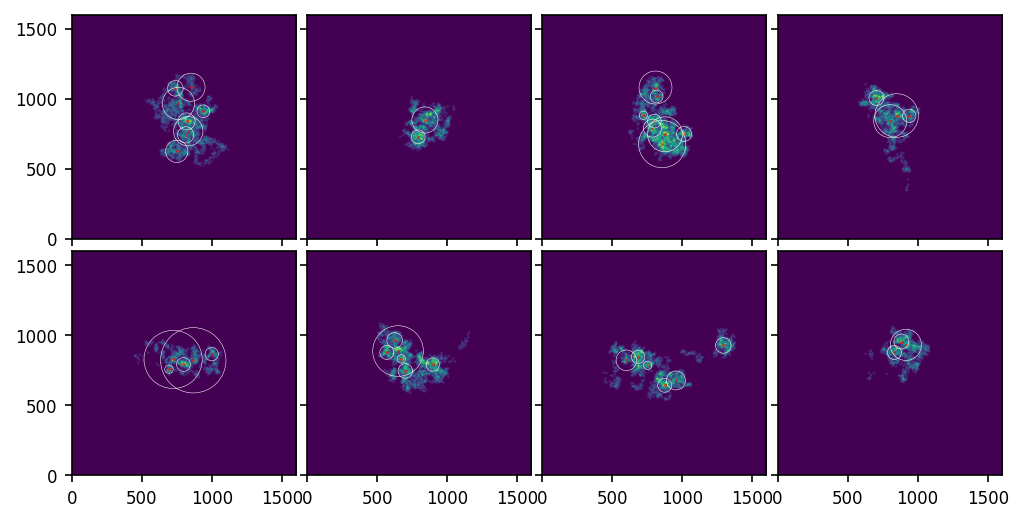

In [7]:
for name, _all_results in all_results.items():
    f, ax = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True, gridspec_kw={'hspace':0.05, 'wspace':0.05})
    examples = _all_results[::len(_all_results)//8][:8]
    for ij, results in enumerate(examples):
        analyzer.plot_domains(results, ax=ax[ij // 4, ij % 4], s=.1)
    plt.savefig(f'img/chromstem_domains_{name}.pdf')
    plt.show()

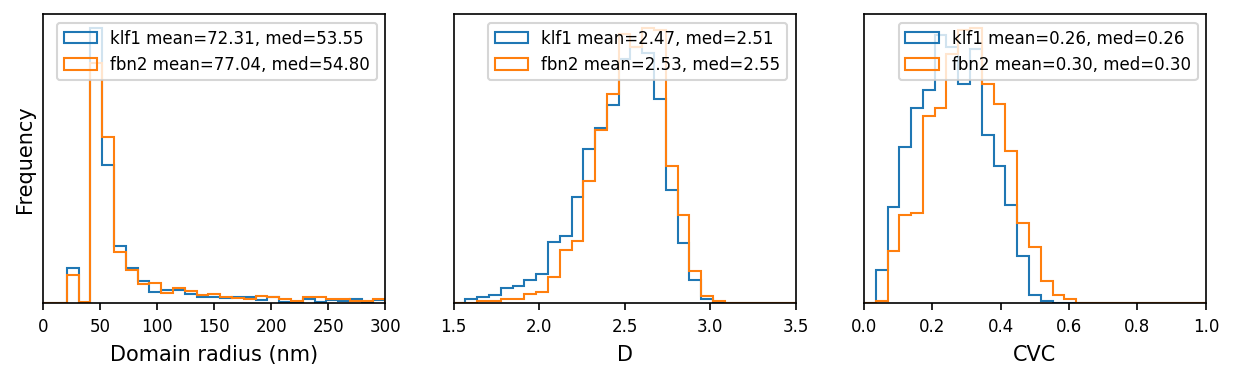

In [8]:
f, ax = plt.subplots(1, 3, figsize=(10, 2.5))
for name in all_results:
    _all_results = all_results[name]
    rfs = np.concatenate([results['rfs'] for results in _all_results])
    ds = np.array([p[1]  for results in _all_results for p in results['params']]) + 1
    cvcs = np.concatenate([results['cvcs'] for results in _all_results])

    myhist(ax[0], rfs, np.linspace(0, 300, 30), name)
    ax[0].set_xlabel('Domain radius (nm)')
    ax[0].set_ylabel('Frequency')
    ax[0].set_yticks([])

    myhist(ax[1], ds, np.linspace(1.5, 3.5, 30), name)
    ax[1].set_xlabel('D')
    ax[1].set_xlabel('D')
    ax[1].set_yticks([])

    myhist(ax[2], cvcs, np.linspace(0, 1, 30), name)
    ax[2].set_xlabel('CVC')
    ax[2].set_yticks([])
for a in ax:
    a.legend(loc='upper right')

plt.savefig(f'img/chromstem_stats.pdf')
plt.show()

# STORM

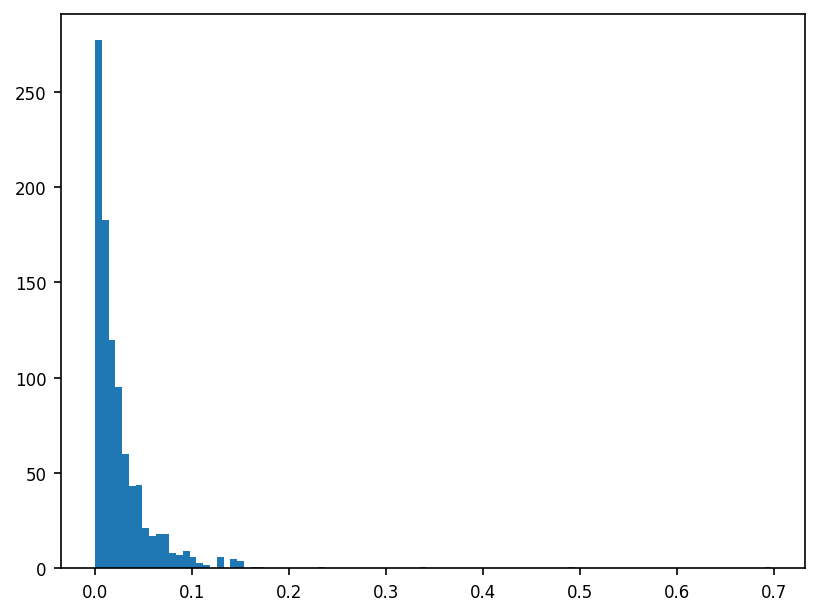

/tmp/ipykernel_1226190/2647268361.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis') # viridis_r goes yellow -> purple/blue


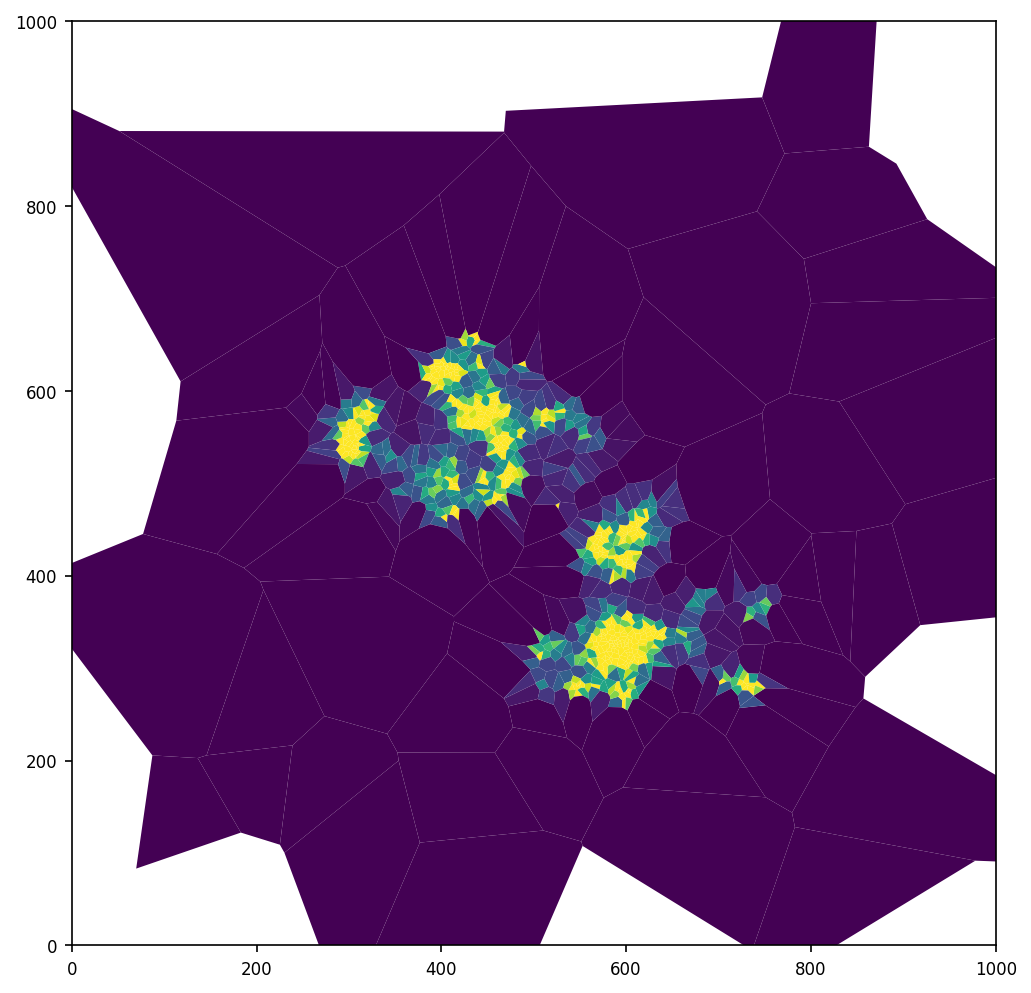

In [10]:
import numpy as np
from scipy.spatial import Voronoi, ConvexHull
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def voronoi_analysis_2d(points):
    # 1. Construct Voronoi diagram
    vor = Voronoi(points)
    
    # 2. Calculate areas and densities
    # Note: Finite regions only; points on the edge have infinite Voronoi areas
    areas = []
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if -1 in region or len(region) == 0:
            areas.append(np.inf) # Edge case
        else:
            # Equivalent to MATLAB's polyarea
            polygon_vertices = vor.vertices[region]
            areas.append(ConvexHull(polygon_vertices).volume)
            
    areas = np.array(areas)
    # Local density = 1 / Area
    densities = 1.0 / areas
    
    return vor, areas, densities

def plot_voronoi_custom(vor, areas):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Define thresholds based on your description
    upper_cutoff = np.nanpercentile(areas[np.isfinite(areas)], 99.5)
    
    # Create a colormap: Yellow (small area/high density) to Blue (large area/low density)
    cmap = plt.cm.get_cmap('viridis') # viridis_r goes yellow -> purple/blue
    
    for i, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 not in region and len(region) > 0:
            polygon = vor.vertices[region]
            area = areas[i]
            low, high = 0.001, 0.02
            norm_val = np.clip((1 / area - low) / (high - low), 0, 1)
            color = cmap(norm_val)
                
            ax.fill(*zip(*polygon), color=color, edgecolor='none')

    ax.set_aspect('equal')
    return ax

positions = trajectories['klf1'][0]
storm_simulator = STORMSimulator(slice_thickness=120, decay=False, mean_localizations_per_antibody=3)
localizations, _ = storm_simulator.get_localizations(positions)
localizations = np.vstack([localizations, np.random.uniform(0, 1000, size=(int(0.05*len(localizations)), 3))])
vor, areas, densities = voronoi_analysis_2d(localizations[:, :2])
plt.hist(densities, bins=100)
plt.show()
ax = plot_voronoi_custom(vor, areas)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
plt.show()

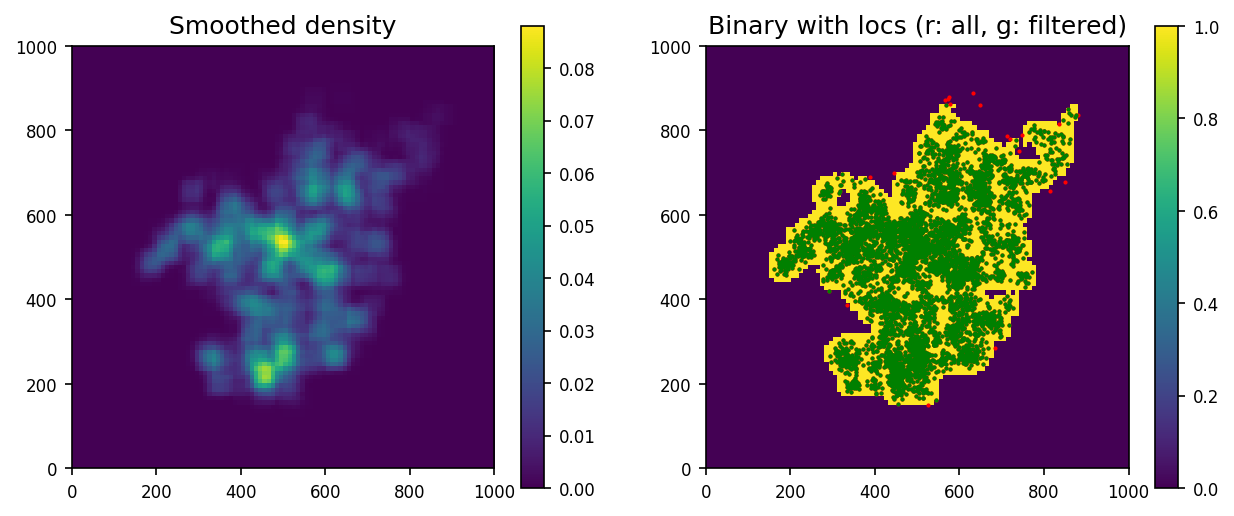

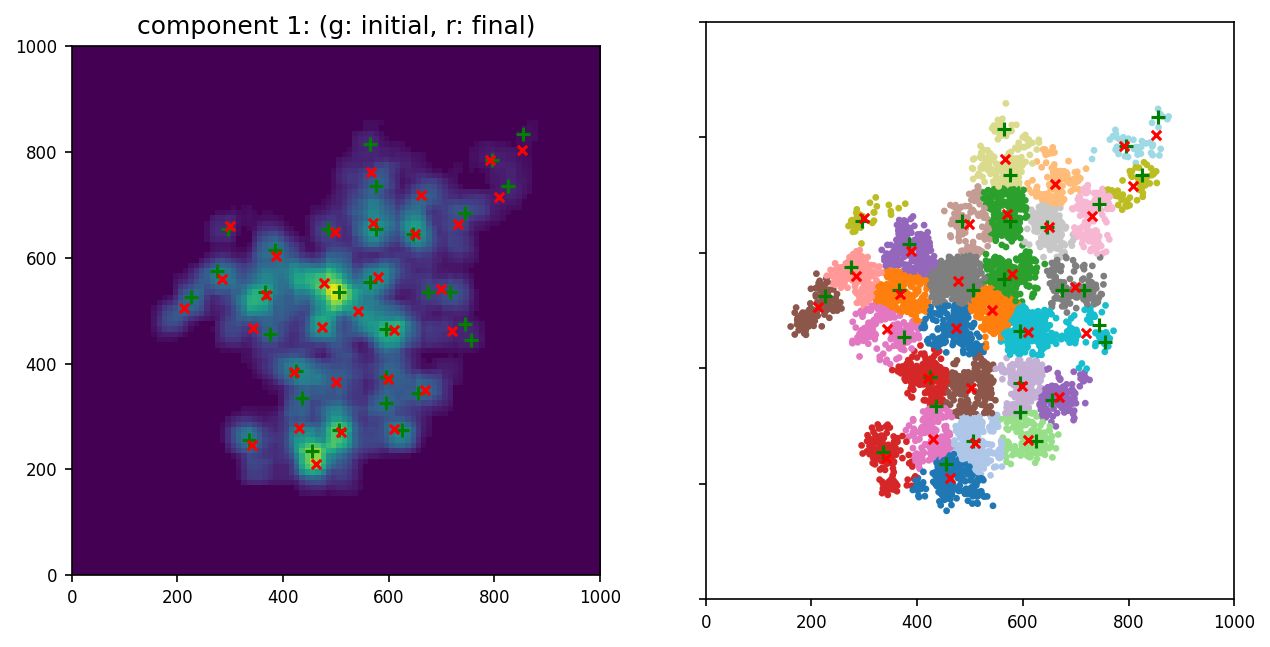

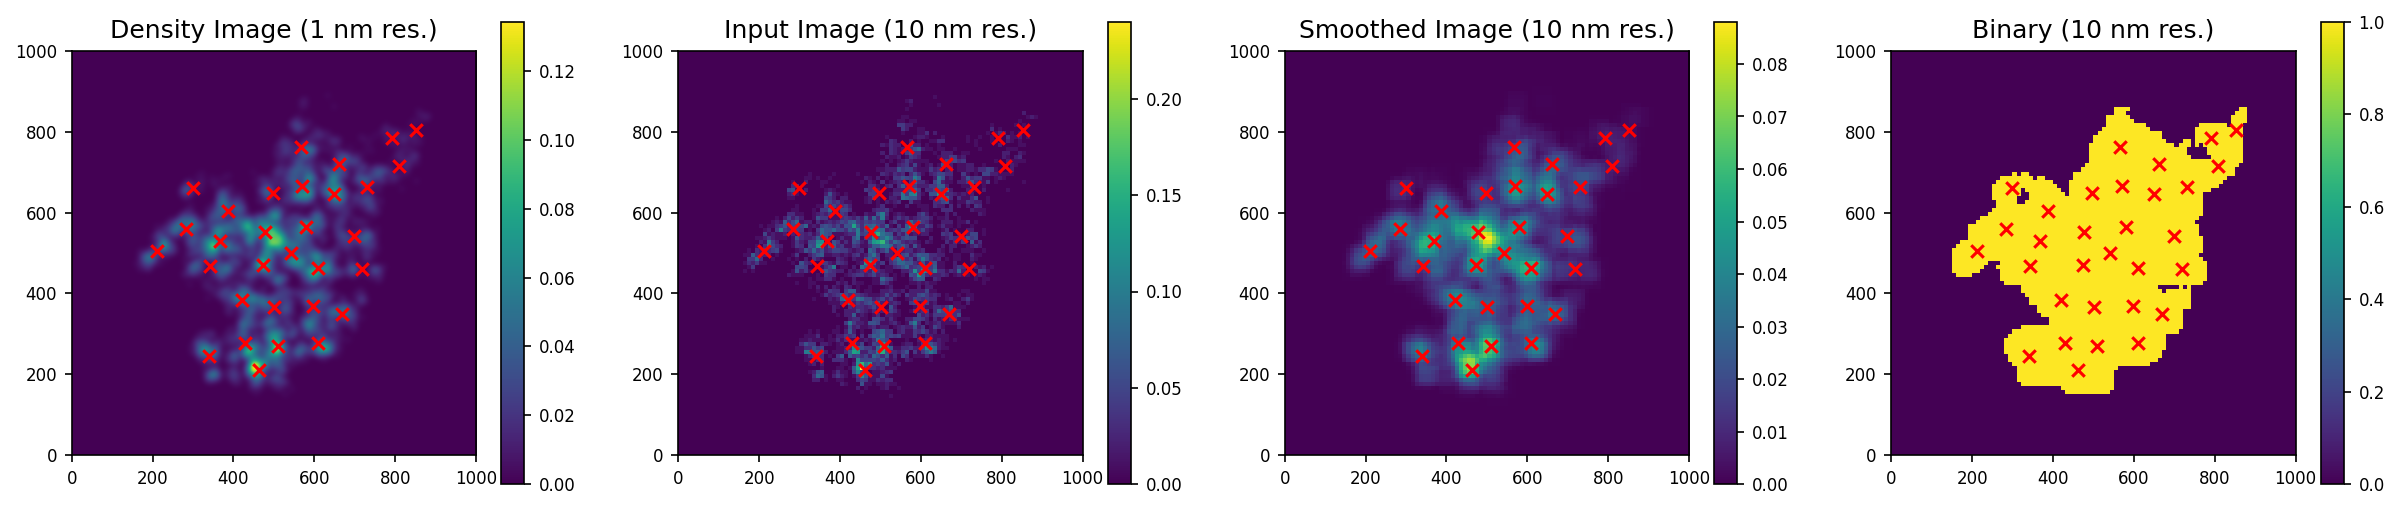

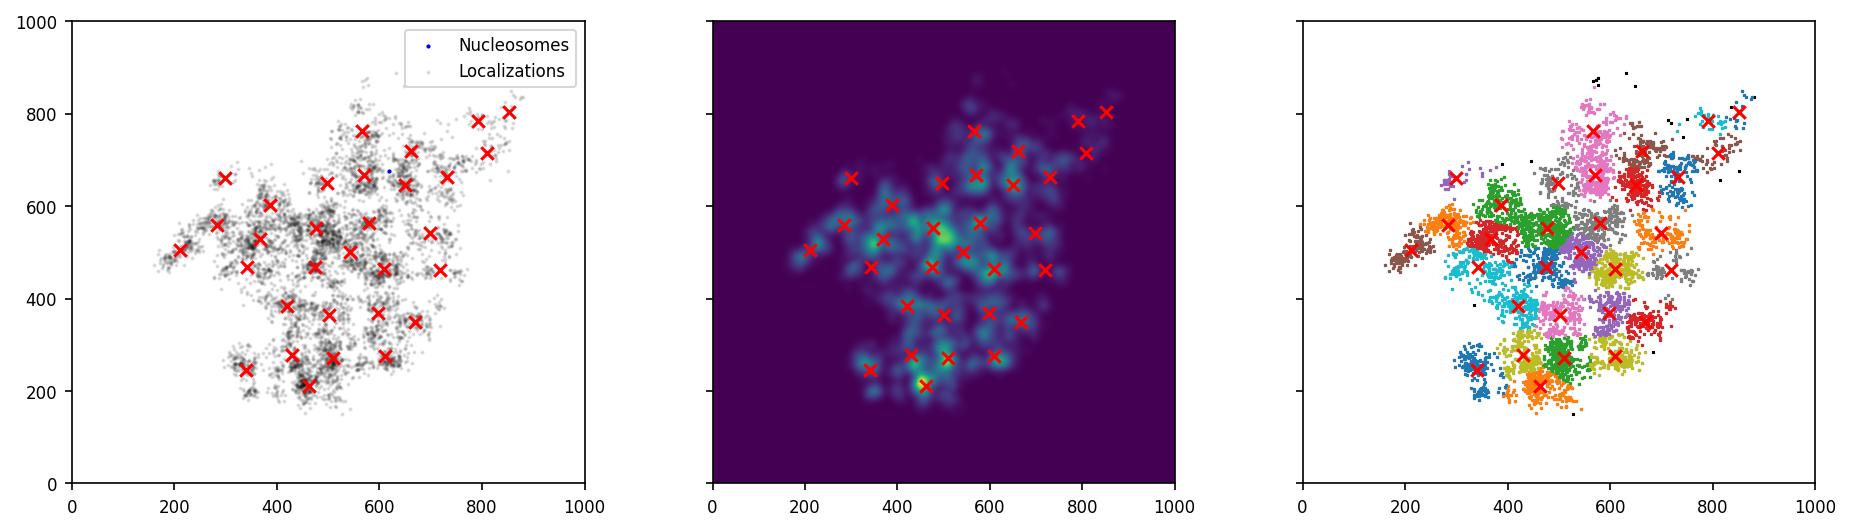

In [11]:
# Debug

positions = trajectories['klf1'][-1]

storm_simulator = STORMSimulator(mean_antibodies_per_nucleosome=0.125)
clutch_analyzer = ClutchAnalyzer()


localizations, localization_to_nucleosome = storm_simulator.get_localizations(positions)
density_image = storm_simulator.get_density_image(localizations)
image = storm_simulator.get_image(localizations)
results, density, binary = clutch_analyzer.run(localizations, image, localization_to_nucleosome, debug=True)

f, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].set_title('Density Image (1 nm res.)')
ax[1].set_title('Input Image (10 nm res.)')
ax[2].set_title('Smoothed Image (10 nm res.)')
ax[3].set_title('Binary (10 nm res.)')
plot_density(density_image, ax[0], resolution=1, colorbar=True)
plot_density(image, ax[1], resolution=10, colorbar=True)
plot_density(density, ax[2], resolution=10, colorbar=True)
plot_density(binary, ax[3], resolution=10, colorbar=True)

for a in ax:
    for clutch in results:
        a.scatter(clutch['centroid_x'], clutch['centroid_y'], color='red',  marker='x')
plt.show()


f, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
slice_weights = storm_simulator.slice_weights(positions)
ax[0].scatter(positions[slice_weights==1, 0]+storm_simulator.width/2, positions[slice_weights==1, 1]+storm_simulator.width/2, s=1, color='blue', label='Nucleosomes')
ax[0].scatter(localizations[:, 0], localizations[:, 1], s=1, alpha=0.1, color='black', label='Localizations')
ax[0].legend()
plot_density(density_image, ax[1], resolution=1, colorbar=False)

ax[2].scatter(localizations[:, 0], localizations[:, 1], s=1, alpha=1, color='black', label='Localizations', marker='+')
for clutch in results:
    ax[2].scatter(clutch['pts'][:, 0], clutch['pts'][:, 1], marker='+', s=1)

for a in ax:
    for clutch in results:
        a.scatter(clutch['centroid_x'], clutch['centroid_y'], color='red',  marker='x')
plt.show()

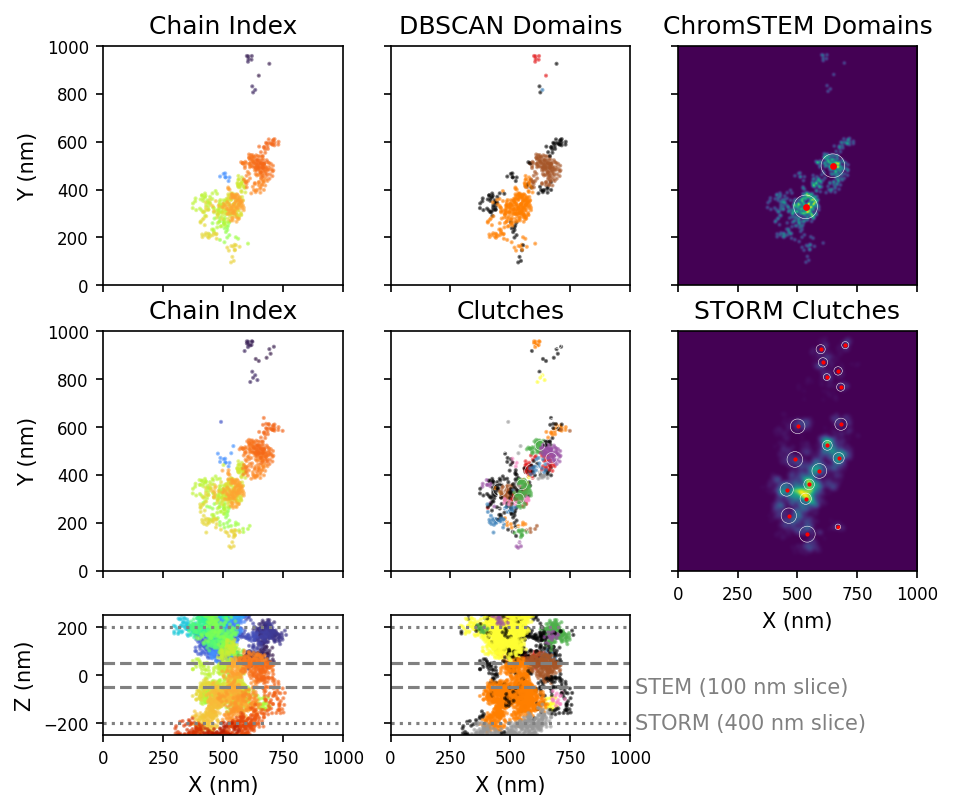

In [15]:
positions = trajectories['klf1'][7]

stem_simulator = ChromSTEMSimulator(width=1000)
storm_simulator = STORMSimulator(slice_thickness=100)

dbscan_analyzer = DomainAnalyzer(30, 200, min_loop_size=2, add_boundary_linkers=True)
stem_analyzer = ChromSTEMAnalyzer(rf_density_increase_factor=float('inf'), peak_threshold=0.75, filter_radius=15)
clutch_analyzer = ClutchAnalyzer()

stem_image = stem_simulator.simulate(positions)
stem_results = stem_analyzer.run(stem_image)

localizations, localizations_to_nucleosomes = storm_simulator.get_localizations(positions)
storm_image = storm_simulator.get_image(localizations)
storm_density_image = storm_simulator.get_density_image(localizations)
storm_results, density, binary = clutch_analyzer.run(localizations, storm_image, localizations_to_nucleosomes)

domain = dbscan_analyzer.analyze_frame(positions)
stem_mask = stem_simulator.slice_weights(positions) > 0
storm_mask = storm_simulator.slice_weights(positions) > 0.5

insulation_scores = get_insulation_scores(np.expand_dims(positions, axis=0), windows=[10])[10][0]
insulation_scores[np.isinf(insulation_scores)] = np.nanmin(insulation_scores)
ins_domain = Domains(positions, get_segments(insulation_scores > -2.5))

_positions = positions.copy()
_positions[:, 0] += storm_simulator.width / 2
_positions[:, 1] += storm_simulator.width / 2

f, ax = plt.subplots(3, 3, figsize=(7, 6), sharex=True, sharey='row', gridspec_kw={'height_ratios':[2, 2, 1]})

s = 1
alpha=0.5
ax[0, 0].set_title('Chain Index')
ax[0, 0].scatter(_positions[stem_mask, 0], _positions[stem_mask, 1], c=np.arange(len(_positions))[stem_mask], cmap='turbo', vmin=0, vmax=len(_positions), s=s, alpha=alpha)
ax[0, 0].set_aspect('equal')
ax[0, 0].set_xlim(0, stem_simulator.width)

ax[1, 0].set_title('Chain Index')
ax[1, 0].scatter(_positions[storm_mask, 0], _positions[storm_mask, 1], c=np.arange(len(_positions))[storm_mask], cmap='turbo', vmin=0, vmax=len(_positions), s=s, alpha=alpha)
ax[1, 0].set_aspect('equal')
ax[1, 0].set_xlim(0, stem_simulator.width)

ax[2, 0].scatter(_positions[:, 0], _positions[:, 2], c=np.arange(len(_positions)), cmap='turbo', vmin=0, vmax=len(_positions), s=s, alpha=alpha)
ax[2, 0].set_ylim(-250, 250)
ax[2, 0].axhline(-50, c='gray', ls='--')
ax[2, 0].axhline(50, c='gray', ls='--')
ax[2, 0].axhline(-200, c='gray', ls=':')
ax[2, 0].axhline(200, c='gray', ls=':')
ax[2, 0].set_aspect('equal')

ax[0, 1].set_title('DBSCAN Domains')
ax[0, 1].scatter(_positions[stem_mask, 0], _positions[stem_mask, 1], c=domain.labels[stem_mask], cmap=domain.colors(), s=s, alpha=alpha, vmin=domain.labels.min(), vmax=domain.labels.max())
ax[0, 1].set_aspect('equal')

ax[1, 1].set_title('Clutches')
ax[1, 1].scatter(_positions[storm_mask, 0], _positions[storm_mask, 1], c=ins_domain.labels[storm_mask], cmap=ins_domain.colors(), s=s, alpha=alpha, vmin=ins_domain.labels.min(), vmax=ins_domain.labels.max())
ax[1, 1].set_aspect('equal')

ax[2, 1].scatter(_positions[:, 0], _positions[:, 2], c=domain.labels, cmap=domain.colors(), s=s, alpha=alpha, vmin=domain.labels.min(), vmax=domain.labels.max())
ax[2, 1].set_ylim(-250, 250)
ax[2, 1].axhline(-50, c='gray', ls='--')
ax[2, 1].axhline(50, c='gray', ls='--')
ax[2, 1].axhline(-200, c='gray', ls=':')
ax[2, 1].axhline(200, c='gray', ls=':')
ax[2, 1].set_aspect('equal')

ax[0, 2].set_title('ChromSTEM Domains')
stem_analyzer.plot_domains(stem_results, ax=ax[0, 2])

ax[1, 2].set_title('STORM Clutches')
plot_density(storm_density_image, resolution=1, ax=ax[1, 2])
for clutch in storm_results:
    ax[1, 2].scatter(clutch['centroid_x'], clutch['centroid_y'], color='red', s=1)
    # Draw elipse with sdx and sdy
    ax[1, 2].add_patch(plt.Circle((clutch['centroid_x'], clutch['centroid_y']), (clutch['sdx']+clutch['sdy'])/2, color='w', fill=False, lw=0.25))
    ax[1, 1].add_patch(plt.Circle((clutch['centroid_x'], clutch['centroid_y']), (clutch['sdx']+clutch['sdy'])/2, color='w', fill=False, lw=0.25))


ax[2, 2].axis('off')
ax[1, 2].tick_params(axis="x", labelbottom=True)

ax[0, 0].set_ylabel('Y (nm)')
ax[1, 0].set_ylabel('Y (nm)')
ax[2, 0].set_ylabel('Z (nm)')
ax[2, 0].set_xlabel('X (nm)')
ax[2, 1].set_xlabel('X (nm)')
ax[1, 2].set_xlabel('X (nm)')

ax[2, 1].text(
    1.02, -50, "STEM (100 nm slice)",
    transform=ax[2, 1].get_yaxis_transform(),  # x in axes coords, y in data coords
    va="center", ha="left", c='gray'
)

ax[2, 1].text(
    1.02, -200, "STORM (400 nm slice)",
    transform=ax[2, 1].get_yaxis_transform(),  # x in axes coords, y in data coords
    va="center", ha="left", c='gray'
)
plt.show()

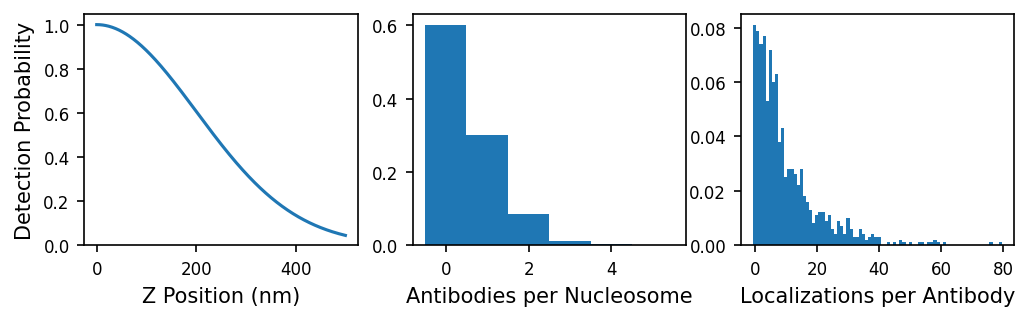

Nucleosomes: 0
Keeping counts > 4 from 13.196 % total
Mean localizations: 12.165201576235223, Median localizations: 9.0
Nucleosomes: 1
Keeping counts > 4 from 6.039 % total
Mean localizations: 13.401225368438483, Median localizations: 10.0
Nucleosomes: 12
Keeping counts > 4 from 32.926 % total
Mean localizations: 34.954261070278804, Median localizations: 26.0
Nucleosomes: 24
Keeping counts > 4 from 38.094 % total
Mean localizations: 60.427967658948916, Median localizations: 48.0


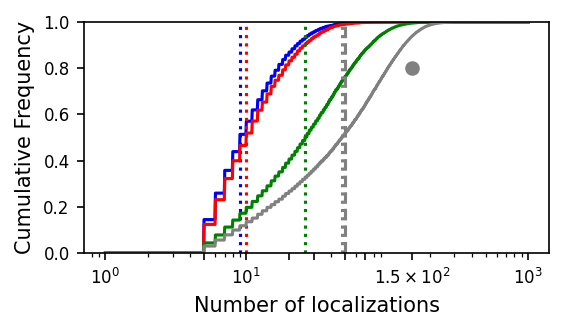

In [16]:
from copy import copy

def get_counts(simulator, n_nucs, trials=100000, z_spread=1000):
    counts = []
    for _ in range(trials):
        positions = np.array([[0, 0, 0] for _ in range(n_nucs)]).astype(float)
        positions[:, 2] += np.random.randn()*z_spread
        localizations, _ = simulator.get_localizations(positions)
        counts += [len(localizations)]
    return np.array(counts)

def calibration_experiment(simulator):
    f,ax = plt.subplots(1, 1, figsize=(4, 2))
    for color, n_nucs in [('blue', 0), ('red', 1), ('green', 12), ('gray', 24)]:
        if n_nucs == 0:
            _simulator = copy(simulator)
            _simulator.antibody_counts = lambda positions: np.ones(positions.shape[0], dtype=int)
            counts = get_counts(_simulator, 1)
        else:
            counts = get_counts(simulator, n_nucs)

        print(f"Nucleosomes: {n_nucs}")
        print(f"Keeping counts > 4 from {np.mean(counts > 4)*100} % total")
        counts = counts[counts > 4]
        print(f"Mean localizations: {np.mean(counts)}, Median localizations: {np.median(counts)}")
        x = np.logspace(0, 3, 1000)
        cdf = np.array([np.sum(np.array(counts) <= xi) for xi in x]) / len(counts)
        plt.axvline(np.median(counts), ls=':', c=color)
        plt.plot(x, cdf, c=color)

    plt.scatter(150, 0.8, c='gray')
    plt.axvline(50, c='gray', ls='--')
    plt.xlabel('Number of localizations')
    plt.ylabel('Cumulative Frequency')
    plt.xscale('log')
    plt.xticks([1, 5, 10, 20, 30, 50, 70, 150, 1000])
    plt.ylim(0, 1)
    plt.show()

simulator = STORMSimulator()
simulator.plot_distributions()
calibration_experiment(simulator)

In [17]:
def plot_all_results(all_results, min_localizations=3):
     f, ax = plt.subplots(1, 5, figsize=(15, 3))
     for name, _all_results in all_results.items():
          __all_results = []
          for results in _all_results:
               filtered_results = [r for r in results[0] if r['n_localizations'] >= min_localizations]
               results = (filtered_results, results[1], results[2])
               __all_results += [results]
          _all_results = __all_results

          all_dists = []
          for results in _all_results:
               centers = np.array([[r['centroid_x'], r['centroid_y']] for r in results[0]])
               if len(centers) < 2:
                    continue
               dists = np.sqrt(np.sum((centers[:, None, :] - centers[None, :, :])**2, axis=2))
               np.fill_diagonal(dists, np.inf)
               all_dists += [dists.min(axis=1)]
          all_dists = np.concatenate(all_dists)

          myhist(ax[0], all_dists, np.linspace(0, 300, 40), name)
          ax[0].set_xlabel('Distance to nearest cluster (nm)')

          areas = np.array([r['area'] for results in _all_results for r in results[0]])
          myhist(ax[1], areas, np.logspace(np.log10(10), np.log10(100_000), 40), name)
          ax[1].set_xlabel('Cluster area (nm$^2$)')
          ax[1].set_xscale('log')

          n_localizations = np.array([r['n_localizations'] for results in _all_results for r in results[0]])
          myhist(ax[2], n_localizations, np.logspace(np.log10(1), np.log10(10000), 40), name)
          ax[2].set_xlabel('# Localizations')
          ax[2].set_xscale('log')

          n_nucleosomes = np.array([r['nucleosomes'].size for results in _all_results for r in results[0]])
          myhist(ax[3], n_nucleosomes, np.logspace(np.log10(1), np.log10(10000), 40), name)
          ax[3].set_xlabel('# Nucleosomes')
          ax[3].set_xscale('log')

          mask = areas > 0
          myhist(ax[4], n_nucleosomes[mask] / areas[mask], np.linspace(0, 0.2, 40), name, precision=3)
          ax[4].set_xlabel('Nucleosomes / nm$^2$')

     for a in ax:
          a.set_yticks([])
          a.legend(loc='upper right')

Antibodies per nucleosome: 1.0, Z offset: 0


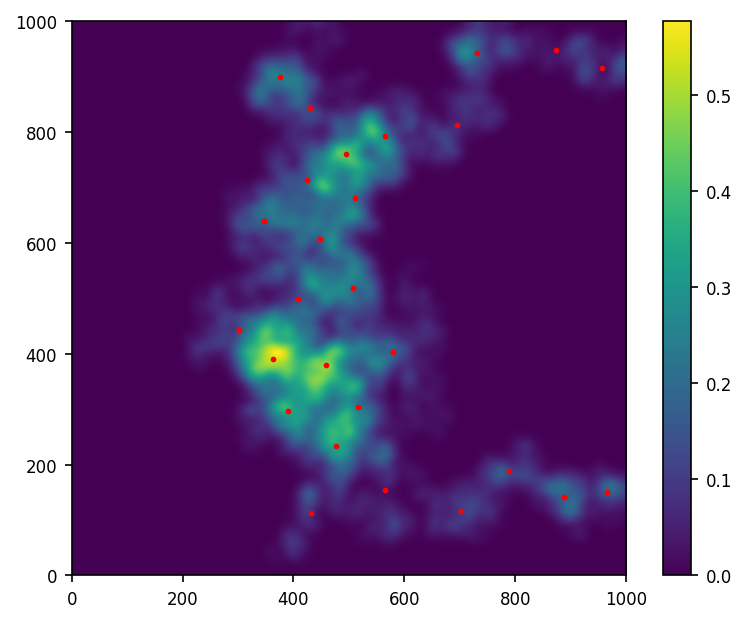

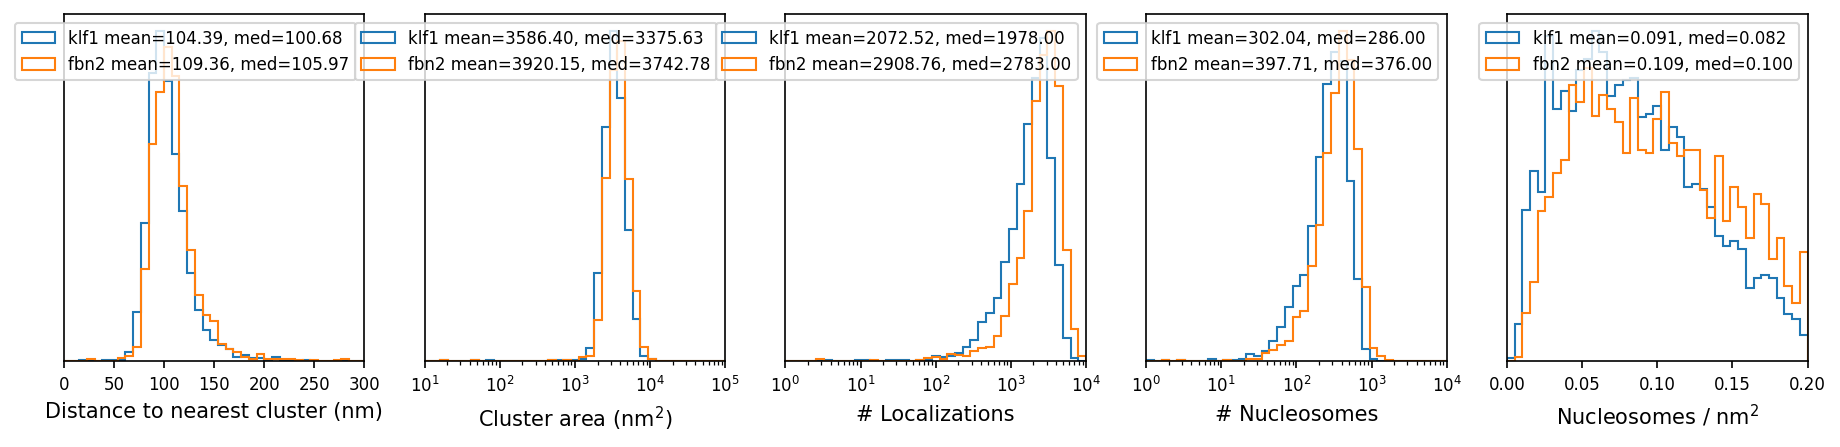

Antibodies per nucleosome: 1.0, Z offset: 1000


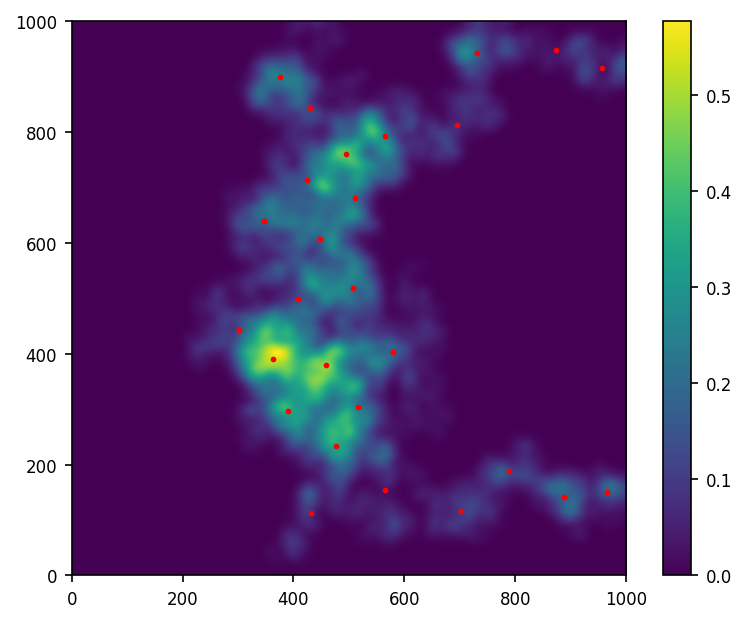

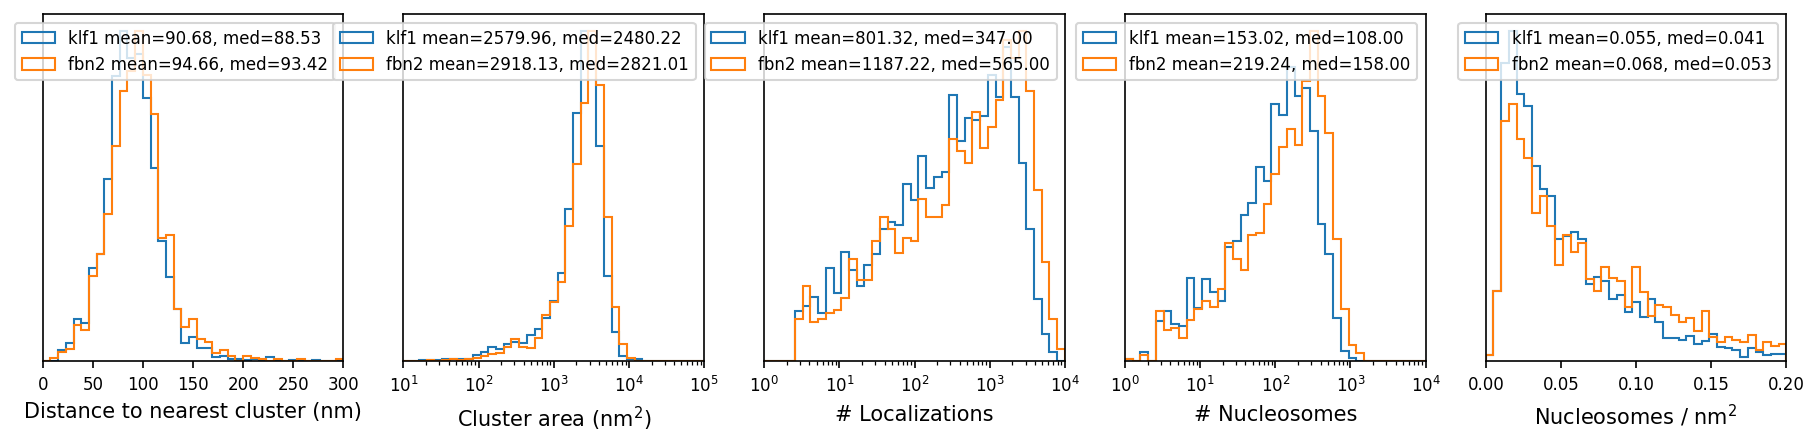

Antibodies per nucleosome: 0.5, Z offset: 0


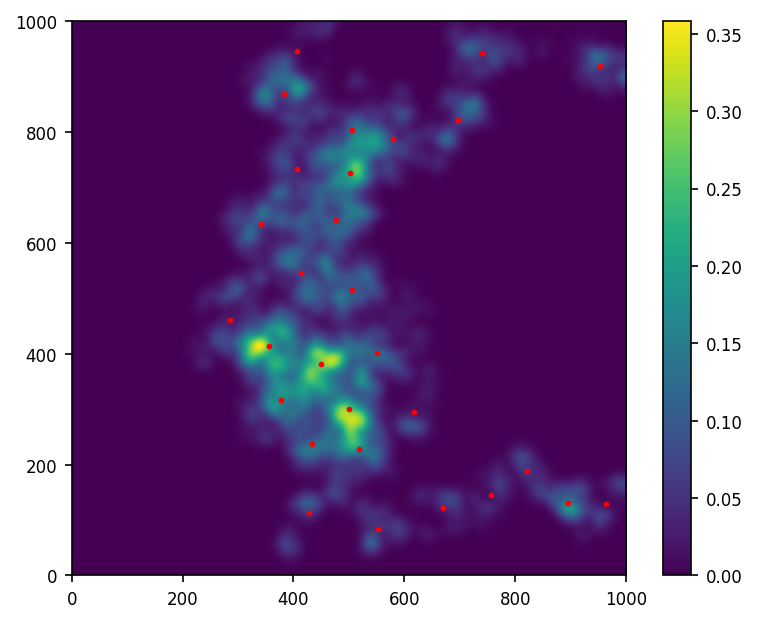

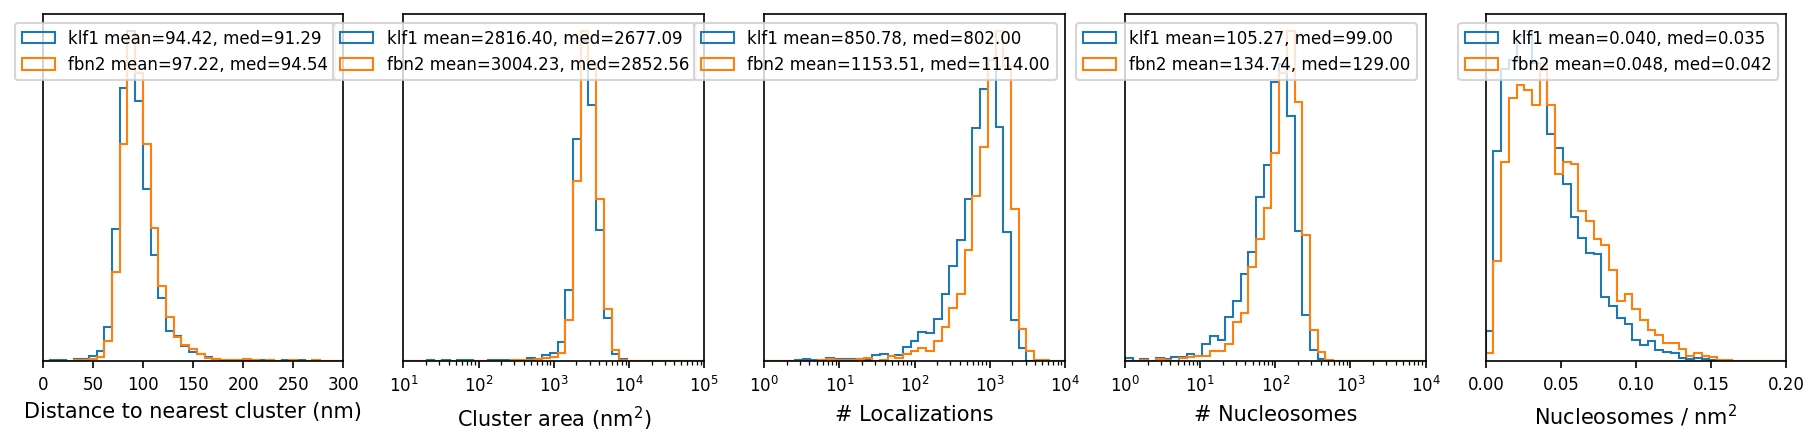

Antibodies per nucleosome: 0.5, Z offset: 1000


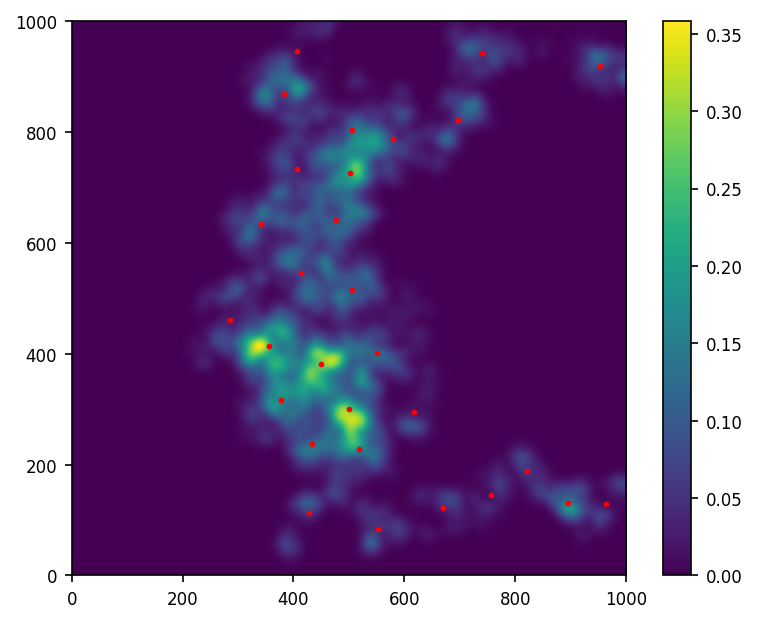

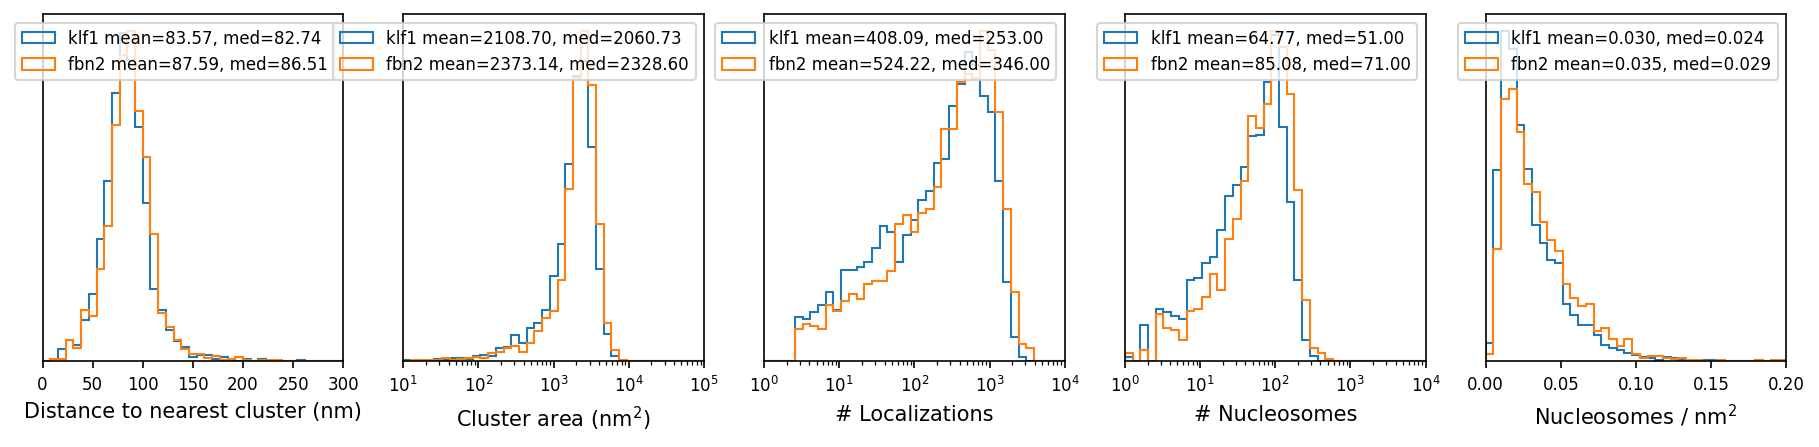

Antibodies per nucleosome: 0.25, Z offset: 0


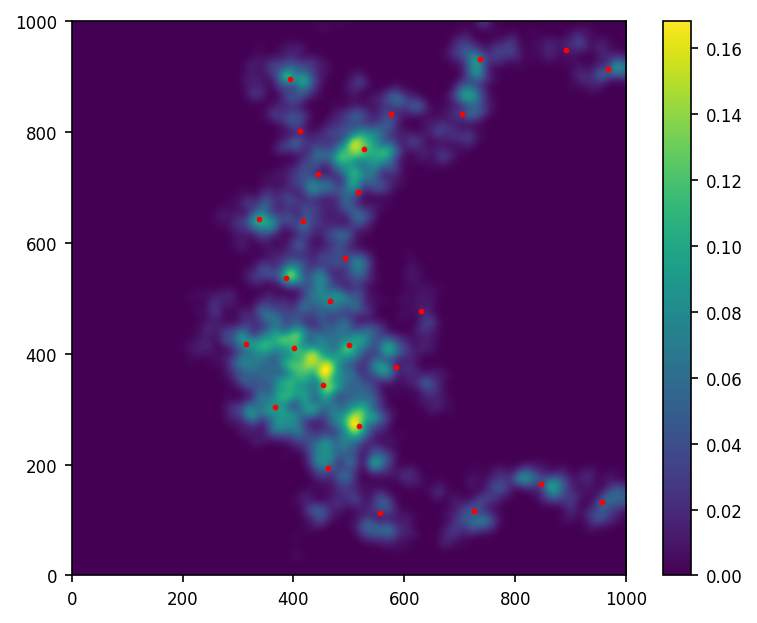

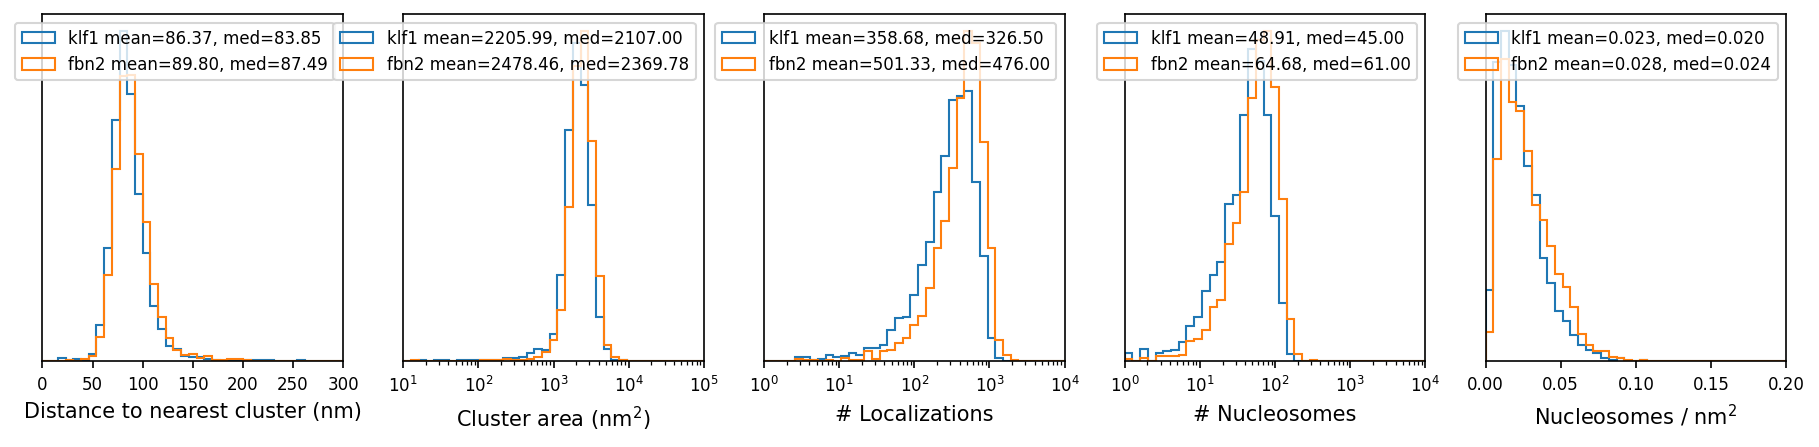

Antibodies per nucleosome: 0.25, Z offset: 1000


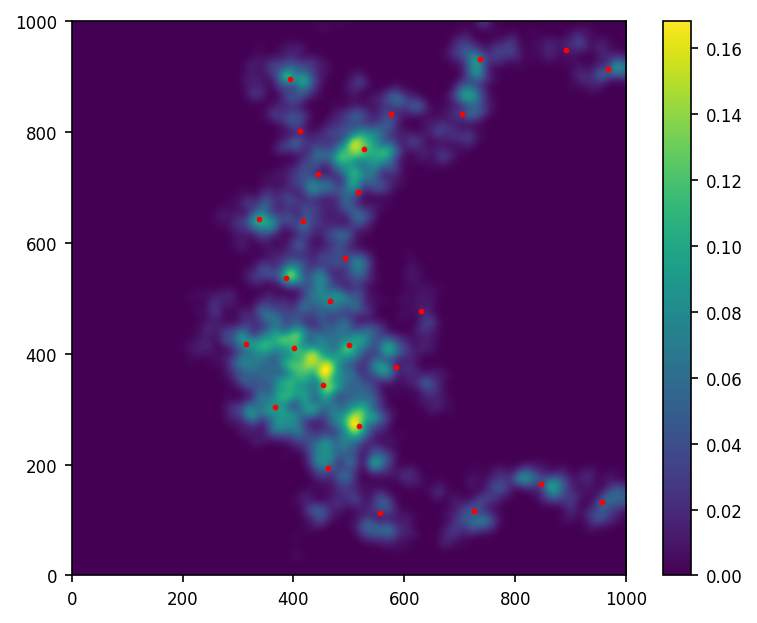

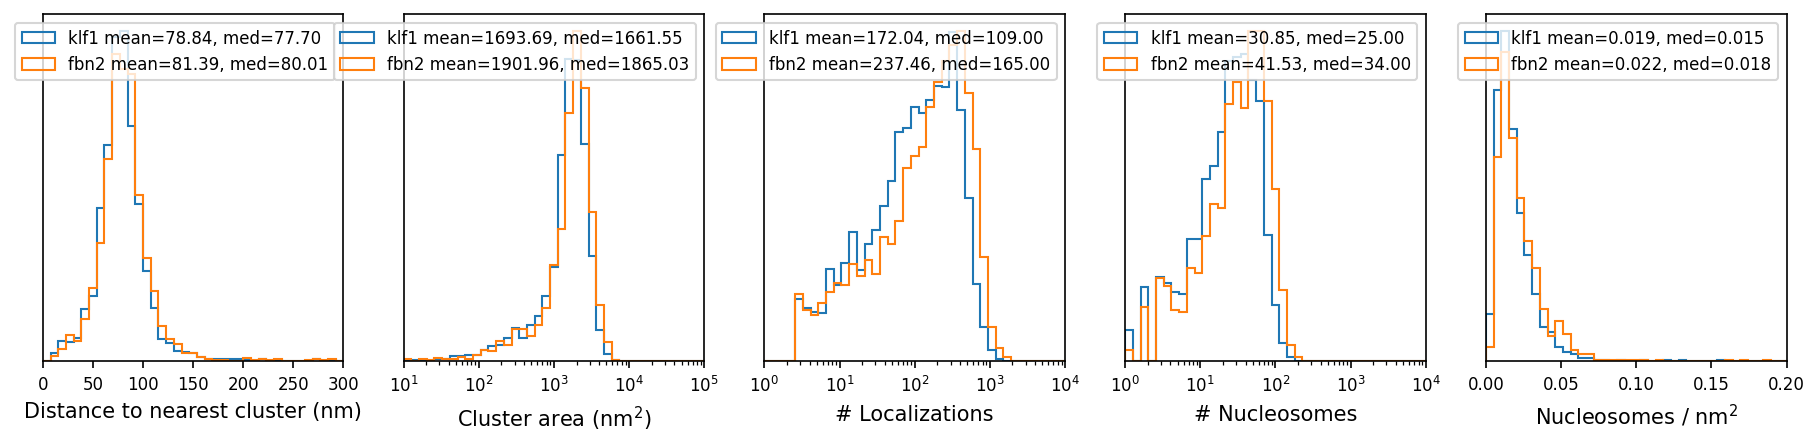

Antibodies per nucleosome: 0.125, Z offset: 0


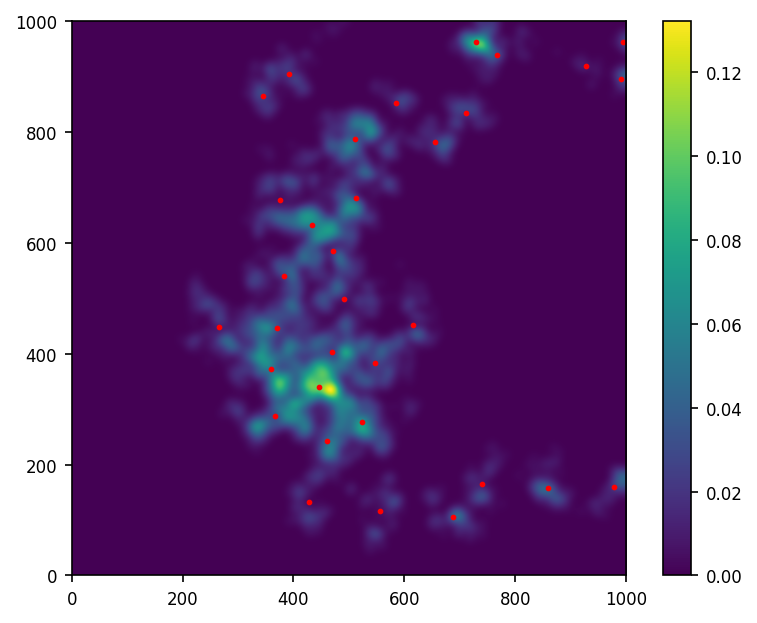

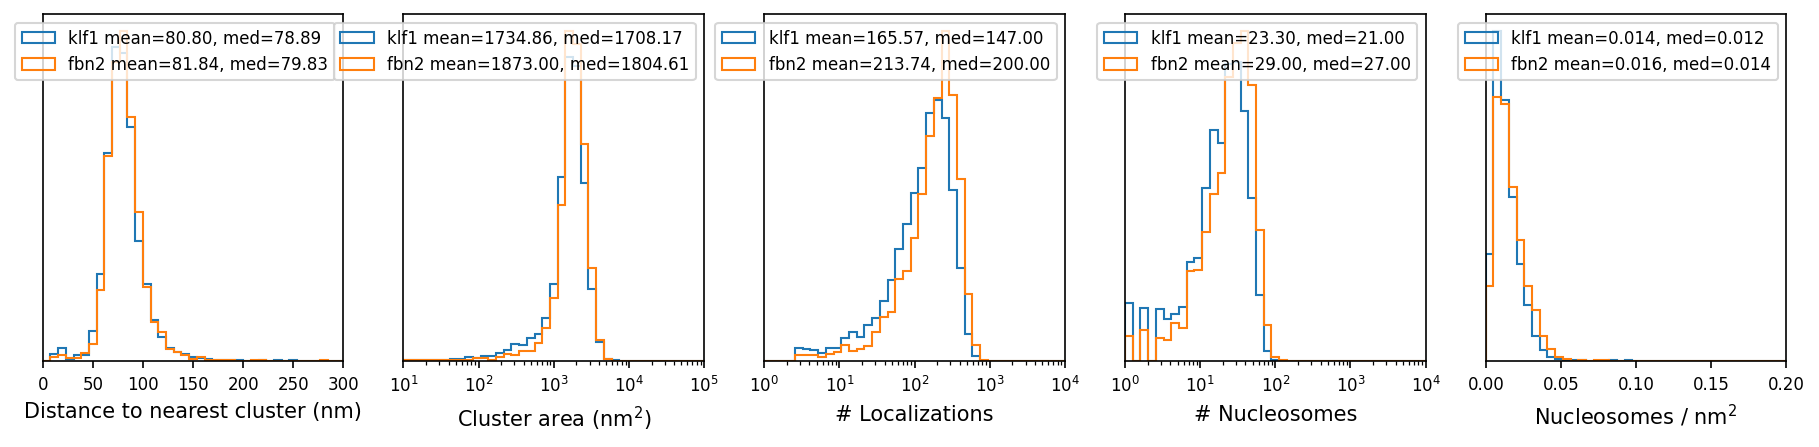

Antibodies per nucleosome: 0.125, Z offset: 1000


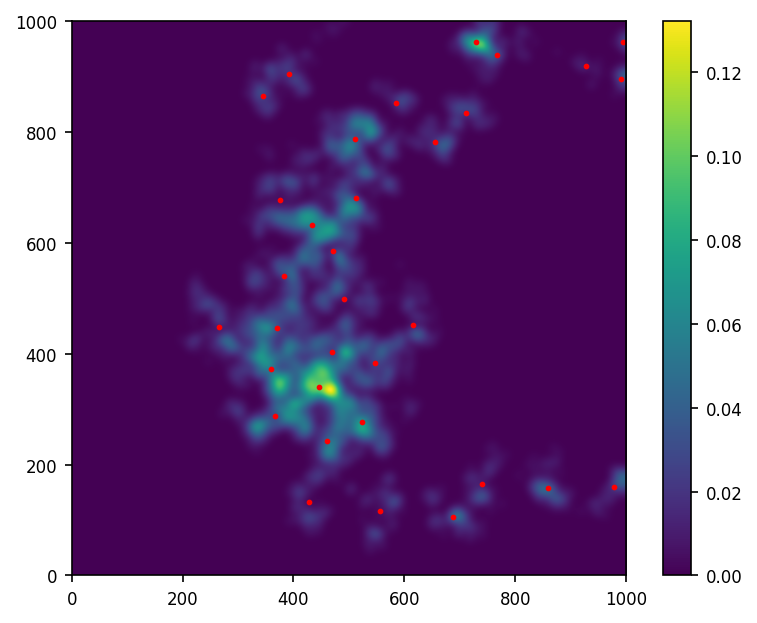

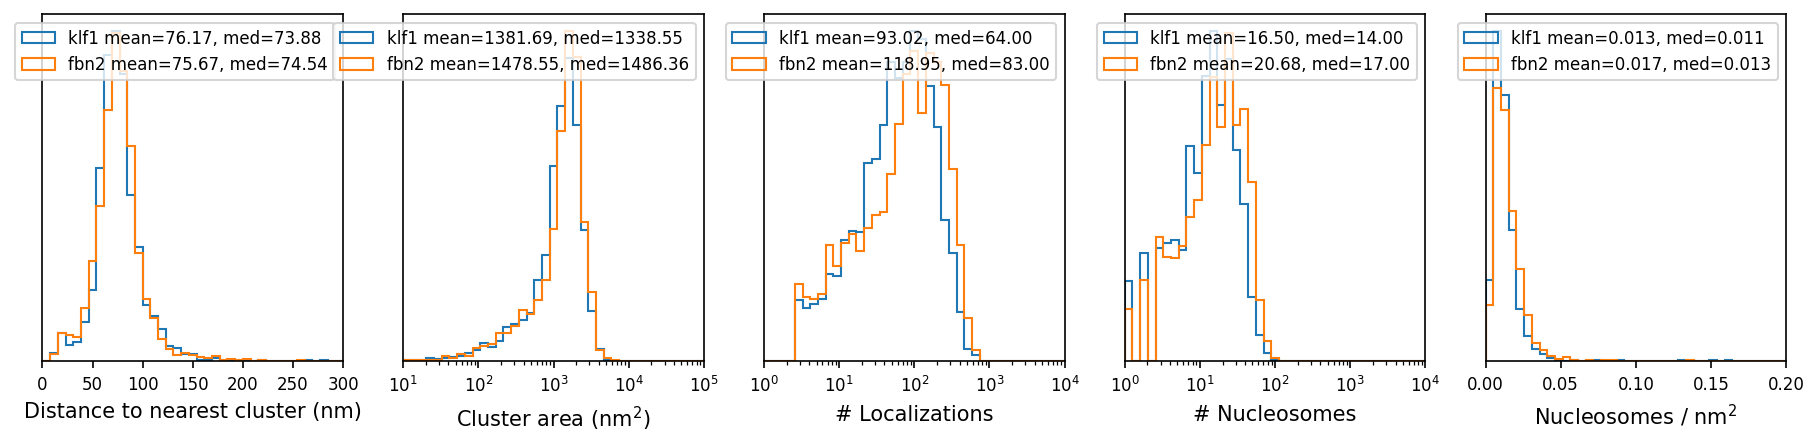

Antibodies per nucleosome: 0.0625, Z offset: 0


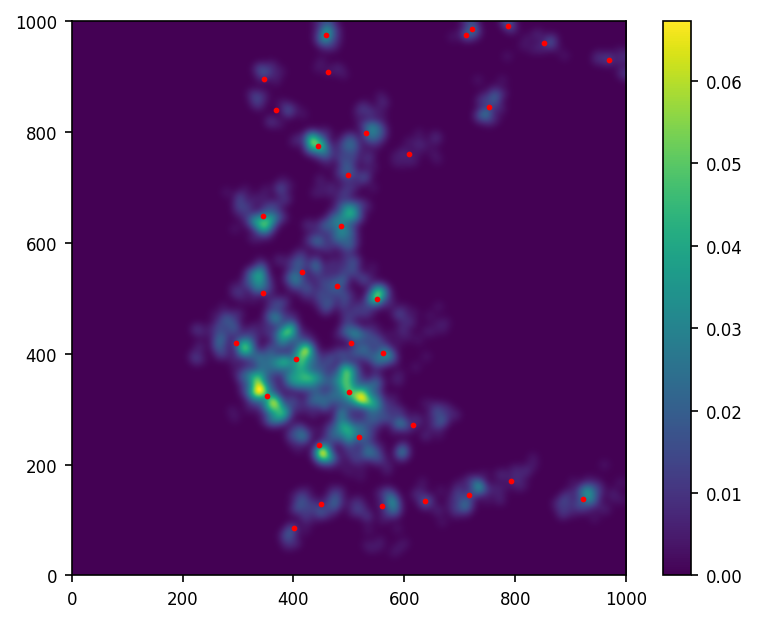

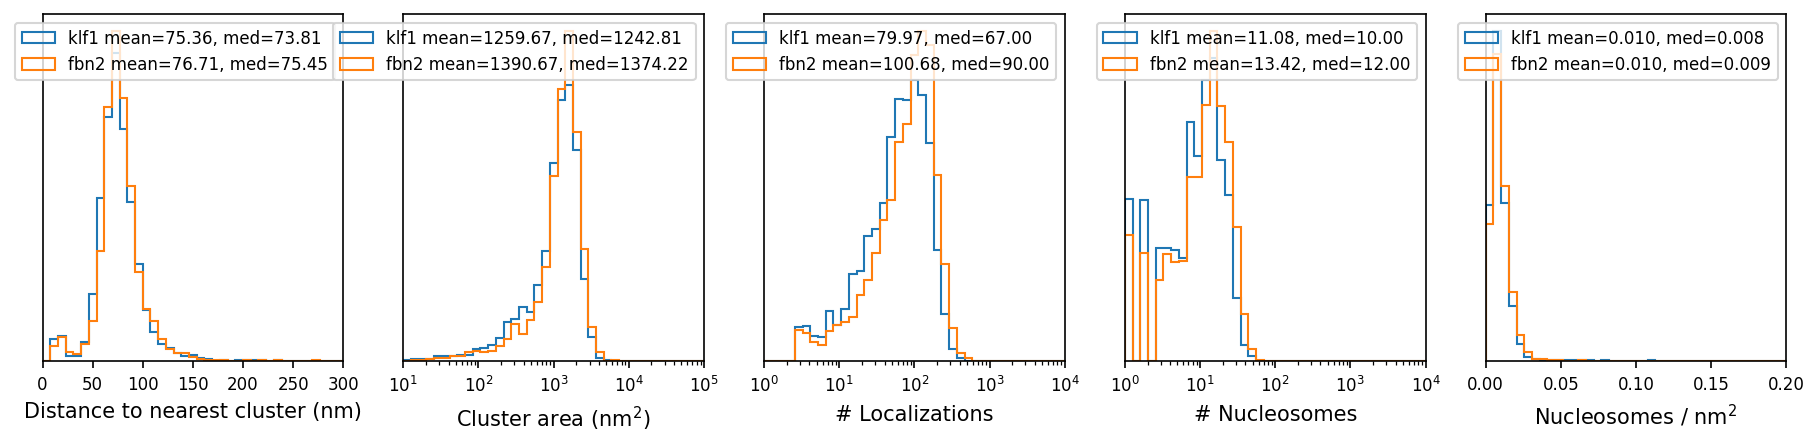

Antibodies per nucleosome: 0.0625, Z offset: 1000


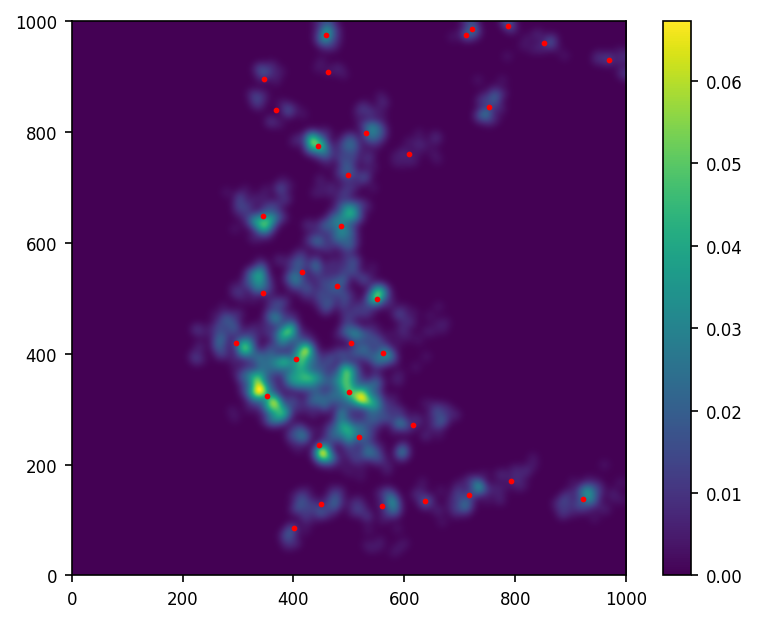

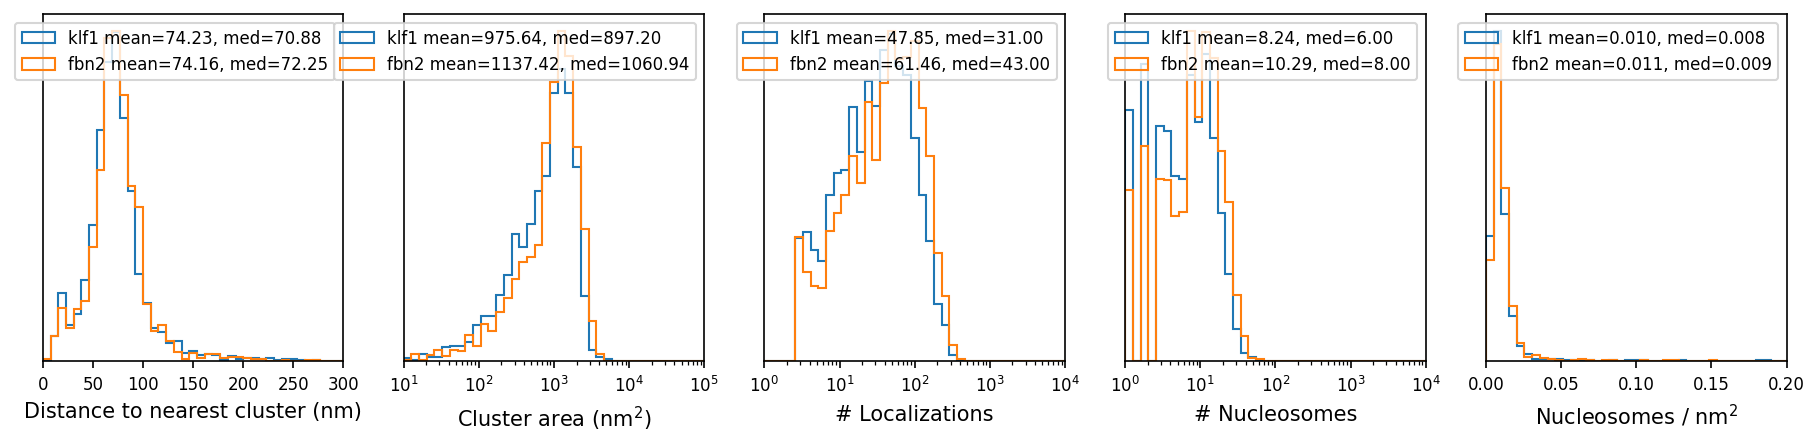

In [18]:
for mean_antibodies_per_nucleosome in [1.0, 0.5, 0.25, 0.125, 0.0625]:
    for z_offset in [0, 1000]:
        np.random.seed(0)
        print(f"Antibodies per nucleosome: {mean_antibodies_per_nucleosome}, Z offset: {z_offset}")
        storm_simulator = STORMSimulator(mean_antibodies_per_nucleosome=mean_antibodies_per_nucleosome)
        clutch_analyzer = ClutchAnalyzer()

        if mean_antibodies_per_nucleosome == 1.0:
            storm_simulator.antibody_counts = lambda positions: np.ones(positions.shape[0], dtype=int)

        example = trajectories['klf1'][154]
        localizations, localization_to_nucleosome = storm_simulator.get_localizations(example)
        results = clutch_analyzer.run(localizations, storm_simulator.get_image(localizations), localization_to_nucleosome)
        plot_density(storm_simulator.get_density_image(localizations), plt.gca(), resolution=1, colorbar=True)
        for clutch in results[0]:
            plt.scatter(clutch['centroid_x'], clutch['centroid_y'], c='r', s=3)
        plt.savefig(f'img/density_z_offset_{z_offset}_antibodies_per_nucleosome_{mean_antibodies_per_nucleosome}.png')
        plt.show()

        all_results = {}
        for name in ['fbn2', 'klf1']:
            all_results[name] = []
            for positions in trajectories[name]:
                positions = positions + np.array([0, 0, 2*z_offset*np.random.rand() - z_offset])
                localizations, localization_to_nucleosome = storm_simulator.get_localizations(positions)
                image = storm_simulator.get_image(localizations)
                all_results[name] += [clutch_analyzer.run(localizations, image, localization_to_nucleosome)]

        plot_all_results({k: all_results[k] for k in ['klf1', 'fbn2']})
        plt.savefig(f'img/metrics_z_offset_{z_offset}_antibodies_per_nucleosome_{mean_antibodies_per_nucleosome}.png')
        plt.show()